# Topic Prior Regularizer Tutorial 

The notebook contains the application and impact of `TopicPriorRegularizer` and its version with sampling a priori probabilities $\varphi_t$ from the Dirichlet distribution.

---

# Пример работы с TopicPriorRegularizer.

В ноутбуке рассматривается применение и влияние на тематические модели регуляризатора `TopicPriorRegularizer` и его версии с семплированием априорных вероятностей $\varphi_t$ из распределения Дирихле.

# Contents<a id="contents"></a>

* [Formula](#formula)
* [Data Preparation](#data)
    * [Topics Filtering (so as to Keep Only Two of Them)](#topics-filtering)
    * [Disbalance](#disbalance)
    * [Dataset Initialization](#dataset-init)
* [Model Training](#model-training)
* [Looking at the Models](#exploring-models)
    * [Plots](#plots)
    * [Viewers](#viewers)
* [Semantic Radius Score Computation](#semantic-radius-score)

In [1]:
import csv
import numpy as np
import os
import pandas as pd
import shutil
import tempfile
import tqdm

from numpy import random
from matplotlib import pyplot as plt

In [3]:
import artm
import topicnet

from topicnet.dataset_manager import load_dataset
from topicnet.cooking_machine.dataset import Dataset

from topicnet.cooking_machine.models import TopicModel
from topicnet.cooking_machine.models.semantic_radius_score import SemanticRadiusScore
from topicnet.cooking_machine.models.topic_prior_regularizer import TopicPriorRegularizer
from topicnet.cooking_machine.models.topic_prior_regularizer import TopicPriorSampledRegularizer

from topicnet.viewers.top_documents_viewer import TopDocumentsViewer
from topicnet.viewers.top_tokens_viewer import TopTokensViewer

## Formula<a id="formula"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

$$R(\Phi,\Theta) = \sum_t\sum_w\beta_t\ln\phi_{wt}$$
$$\frac{\partial R}{\partial\Phi_{wt}} = \frac{\beta_t}{\varphi_{wt}}$$

## Data Preparation<a id="data"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

### Data Loading<a id="data-loading"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

The collection to be used for modeling is going to contain 1000 documents on the topic "Business" and 100 documents on the topic "Music".
First, we need to download the full dataset (where there are many tags).
And then we will do a little filtering to make an ubalanced dataset with two tags (i.e. topics).

In [4]:
DATASET_NAME = 'lenta'
DATASET_FILE_NAME = f'{DATASET_NAME}.csv'

# Folder, where all downloaded TopicNet's datasets reside
DATASETS_FOLDER_PATH = os.path.join(
    os.path.dirname(topicnet.__file__),
    'dataset_manager',
)

In [5]:
os.listdir(DATASETS_FOLDER_PATH)

['__pycache__',
 'postnauka.csv',
 'api.py',
 '__init__.py',
 'postnauka__internals',
 'DemoDataset.ipynb']

If dataset not yet on the machine, we'll download it

In [ ]:
if DATASET_FILE_NAME not in os.listdir(DATASETS_FOLDER_PATH):
    _ = load_dataset(DATASET_NAME)

100%|██████████| 462M/462M [00:06<00:00, 73.2MiB/s] 
Dataset downloaded! Save path is: "/home/alekseev/topicnet/dataset_manager/lenta.csv"


In [6]:
assert DATASET_FILE_NAME in os.listdir(DATASETS_FOLDER_PATH)

In [7]:
DATASET_FILE_PATH = os.path.join(
    DATASETS_FOLDER_PATH,
    DATASET_FILE_NAME,
)

The dataset is big, so reading it all like `pd.read_csv()` may lead to memory crash.
Let's look at the header and some row.

In [8]:
df = pd.read_csv(DATASET_FILE_PATH, nrows=1, index_col=0)

In [9]:
df.head()

,url,title,text,topic,tags,lemmatized,year,month,day,time_n,lemmatized_title,topmine,vw_text,id
Unnamed: 0,,,,,,,,,,,,,,
449272,https://lenta.ru/news/2013/01/01/fire2/,В ЮАР четыре тысячи человек остались без крова...,"В ЮАР произошел пожар, в результате которого п...",Мир,Все,юар произойти пожар результат погибнуть ожог т...,2013,1,1,449272,в юар четыре тысяча человек остаться без кров ...,место_настоящее состояние_алкогольный_опьянени...,0 |@word юар произойти пожар результат погибну...,0


Tags we are interested in

In [10]:
TAG_BUSINESS = 'Бизнес'
TAG_MUSIC = 'Музыка'
TAGS_OF_INTEREST = [TAG_MUSIC, TAG_BUSINESS]

COLUMN_NAME_TAGS = 'tags'

In [11]:
WORKING_FOLDER_PATH = tempfile.mkdtemp()

In [12]:
WORKING_FOLDER_PATH

'/tmp/tmpaix3v962'

### Topics Filtering (so as to Keep Only Two of Them)<a id="topics-filtering"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

New dataset which we are going to make: with two topics & unbalanced.

In [13]:
NEW_DATASET_FILE_PATH = os.path.join(WORKING_FOLDER_PATH, DATASET_FILE_NAME)

In [14]:
total_num_rows = None

In [16]:
if total_num_rows is None:
    total_num_rows = 0

    print('Counting rows...')

    with open(DATASET_FILE_PATH, 'r') as f:
        for i, _ in tqdm.tqdm(enumerate(csv.reader(f)), file=sys.stdout):
            total_num_rows += 1


print('Writing new dataset...')

tags_column_index = None
num_rows_of_interest = 0

with open(DATASET_FILE_PATH, 'r') as file_in, open(NEW_DATASET_FILE_PATH, 'w') as file_out:
    reader = csv.reader(file_in)
    writer = csv.writer(file_out)

    for i, row in tqdm.tqdm(enumerate(reader), total=total_num_rows, file=sys.stdout):
        if i == 0:
            tags_column_index = row.index(COLUMN_NAME_TAGS)
            writer.writerow(row)

            continue
        
        if row[tags_column_index] in TAGS_OF_INTEREST:
            writer.writerow(row)
            num_rows_of_interest += 1

Writing new dataset...
100%|██████████| 263558/263558 [00:25<00:00, 10431.68it/s]


In [17]:
print(f'Number of rows in newly created dataset: {num_rows_of_interest}')

Number of rows in newly created dataset: 14044


Let's see what we have

In [18]:
df = pd.read_csv(NEW_DATASET_FILE_PATH, index_col=0)

In [19]:
df.head()

,url,title,text,topic,tags,lemmatized,year,month,day,time_n,lemmatized_title,topmine,vw_text,id
Unnamed: 0,,,,,,,,,,,,,,
450186,https://lenta.ru/news/2013/01/11/simon/,Руководитель Берлинского филармонического орке...,Английский маэстро сэр Саймон Рэттл покинет по...,Культура,Музыка,английский маэстро сэр саймон рэттл покинуть п...,2013,1,11,450186,руководитель берлинский филармонический оркест...,имя_руководить симфонический_оркестр симфониче...,914 |@word английский маэстро сэр саймон рэттл...,914
450389,https://lenta.ru/news/2013/01/14/kubana/,Хедлайнером фестиваля KUBANA-2013 станет Syste...,"Одним из хедлайнеров фестиваля KUBANA, который...",Культура,Музыка,хедлайнер фестиваль kubana пройти черноморский...,2013,1,14,450389,хедлайнер фестиваль kubana стать system of a down,группа_system российский_концерт обещать_поздн...,1117 |@word хедлайнер фестиваль kubana пройти ...,1117
450399,https://lenta.ru/news/2013/01/14/kogan/,Бывший глава Госстроя нацелился на долю в круп...,"Компания ""Нефтегазиндустрия"", принадлежащая бы...",Экономика,Бизнес,компания нефтегазиндустрия принадлежащий бывши...,2013,1,14,450399,бывший глава госстрой нацелиться на доля в кру...,часть_приходиться компания_контролировать уйти...,1127 |@word компания нефтегазиндустрия принадл...,1127
450419,https://lenta.ru/news/2013/01/14/deal/,Крупнейший производитель часов в мире купил ог...,"Швейцарская Swatch Group, крупнейший в мире пр...",Экономика,Бизнес,швейцарский swatch group крупный производитель...,2013,1,14,450419,крупный производитель часы в мир купить огранщ...,договориться_покупка ювелирный_компания_tiffan...,1147 |@word швейцарский swatch group крупный п...,1147
450427,https://lenta.ru/news/2013/01/14/sabbath/,Black Sabbath придумали название новому альбому,Новый альбом рок-группы Black Sabbath выйдет в...,Культура,Музыка,новый альбом рок группа black sabbath выйти на...,2013,1,14,450427,black sabbath придумать название новый альбом,запись_коллектив black_sabbath black_sabbath b...,1155 |@word новый альбом рок группа black sabb...,1155


Just two tags: as we need

In [20]:
df.groupby(COLUMN_NAME_TAGS).count()['id']

tags
Бизнес    8222
Музыка    5822
Name: id, dtype: int64

### Disbalance<a id="disbalance"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

Now let's provide a big disbalance of topics

In [23]:
MAX_NUM_ROWS_FIRST_TAG = 100
DISBALANCE_COEFFICIENT = 10

NUM_TAG_ROWS = list()

NUM_TAG_ROWS.append(min(
    MAX_NUM_ROWS_FIRST_TAG,
    df.groupby(COLUMN_NAME_TAGS).count()['id'][TAGS_OF_INTEREST[0]]
))

NUM_TAG_ROWS.append(
    DISBALANCE_COEFFICIENT * NUM_TAG_ROWS[0]
)

In [24]:
indices_to_drop = []

for tag, num_tag_rows in zip(TAGS_OF_INTEREST, NUM_TAG_ROWS):
    indices_to_drop += list(df[df[COLUMN_NAME_TAGS] == tag].index)[num_tag_rows:]

In [25]:
df.drop(index=indices_to_drop, inplace=True)

Now we are done: we have a disbalanced collection

In [26]:
df.groupby(COLUMN_NAME_TAGS).count()['id']

tags
Бизнес    1000
Музыка     100
Name: id, dtype: int64

In [27]:
df.to_csv(NEW_DATASET_FILE_PATH, index=False)

In [28]:
del df

### Dataset Initialization<a id="dataset-init"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

In [29]:
DATASET = Dataset(NEW_DATASET_FILE_PATH, batch_size=10)
DICTIONARY = DATASET.get_dictionary()
BATCH_VECTORIZER = DATASET.get_batch_vectorizer()

In [30]:
DATASET._data.groupby(COLUMN_NAME_TAGS).count()['id']

tags
Бизнес    1000
Музыка     100
Name: id, dtype: int64

## Model Training<a id="model-training"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

Here we are going to create topic models and explore some of their properties

In [31]:
topic_prior_reg = TopicPriorRegularizer(
    name='topic_prior', tau=5, num_topics=2, beta=[10, 1]
)

Core ARTM models

In [37]:
model_lenta = artm.ARTM(num_topics=2, cache_theta=True)
model_lenta.scores.add(artm.scores.PerplexityScore(name='perplexity'))
model_lenta.initialize(DICTIONARY)

model_lenta_unbalanced = artm.ARTM(num_topics=2, cache_theta=True)
model_lenta_unbalanced.scores.add(artm.scores.PerplexityScore(name='perplexity'))
model_lenta_unbalanced.initialize(DICTIONARY)

TopicNet models

In [38]:
topic_model_lenta = TopicModel(
    artm_model=model_lenta, model_id='model_lenta'
)
topic_model_lenta_unbalanced = TopicModel(
    artm_model=model_lenta_unbalanced, model_id='model_lenta_unbalanced'
)

In [39]:
NUM_FIT_ITERATIONS = 10

In [40]:
%%time

topic_model_lenta._fit(
    BATCH_VECTORIZER,
    num_iterations=NUM_FIT_ITERATIONS,
    custom_regularizers={
        topic_prior_reg.name: topic_prior_reg
    },
)

CPU times: user 22.3 s, sys: 2.73 s, total: 25 s
Wall time: 14.8 s


In [41]:
%%time

topic_model_lenta_unbalanced._fit(
    BATCH_VECTORIZER,
    num_iterations=NUM_FIT_ITERATIONS,
)

CPU times: user 11.1 s, sys: 1 s, total: 12.1 s
Wall time: 4.61 s


Fitting the regularized model took more time

## Looking at the Models<a id="exploring-models"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

In [42]:
print('Balance of documents in a model WITH a regularizer:\n{}\n'.format(
    topic_model_lenta.get_theta().idxmax().value_counts(sort=False)
))

print('Balance of documents in a model WITHOUT a regularizer:\n{}'.format(
    topic_model_lenta_unbalanced.get_theta().idxmax().value_counts(sort=False)
))

Balance of documents in a model WITH a regularizer:
topic_1    941
topic_0    159
dtype: int64

Balance of documents in a model WITHOUT a regularizer:
topic_1    514
topic_0    586
dtype: int64


We can see that the model without regularizer failed to catch the disbalance.
However, this is not the case for the regularized model!

### Plots<a id="plots"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

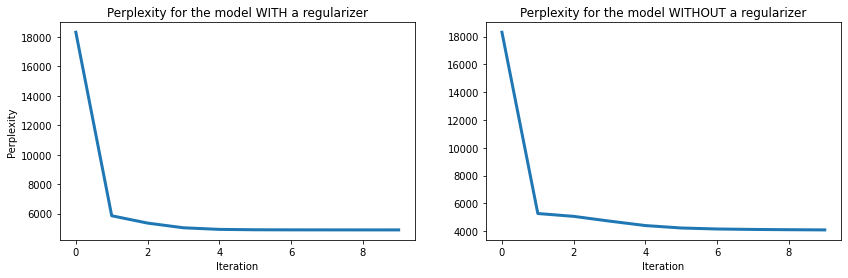

In [47]:
plt.figure(figsize=(14, 4))

LINE_WIDTH = 3
LABEL_X = 'Iteration'
LABEL_Y = 'Perplexity'

plt.subplot(1,2,1)

values = np.array(model_lenta.score_tracker['perplexity'].value)
med = np.median(values)
values[values > 5 * med] = np.nan

plt.title('Perplexity for the model WITH a regularizer')
plt.xlabel(LABEL_X)
plt.ylabel(LABEL_Y)
plt.plot(values, lw=LINE_WIDTH)


plt.subplot(1,2,2)

values = np.array(model_lenta_unbalanced.score_tracker['perplexity'].value)
med = np.median(values)
values[values > 5 * med] = np.nan

plt.title('Perplexity for the model WITHOUT a regularizer')
plt.xlabel(LABEL_X)
plt.plot(values, lw=LINE_WIDTH)

plt.show()

### Viewers<a id="viewers"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

Top-tokens for models' topics:

In [48]:
tokens_viewer = TopTokensViewer(model=topic_model_lenta, num_top_tokens=10)

In [49]:
tokens_viewer.view_from_jupyter()

topic_0 modality token 
 
 @ngramm 
 depeche_mode 
 0.000460 
 
 
 новый_альбом 
 0.000250 
 
 
 студийный_альбом 
 0.000240 
 
 
 новое_альбом 
 0.000210 
 
 
 поступить_продажа 
 0.000170 
 
 
 альбом_группа 
 0.000130 
 
 
 симфонический_оркестр 
 0.000110 
 
 
 филармонический_оркестр 
 0.000110 
 
 
 альбом_запись 
 0.000100 
 
 
 хит_парад 
 0.000100 
 
 topic_0 modality token 
 
 @word 
 альбом 
 0.012980 
 
 
 группа 
 0.012390 
 
 
 музыкант 
 0.003990 
 
 
 концерт 
 0.003380 
 
 
 новый 
 0.003190 
 
 
 запись 
 0.002590 
 
 
 пластинка 
 0.002550 
 
 
 песня 
 0.002540 
 
 
 песнь 
 0.002230 
 
 
 выйти 
 0.002060 
 
   topic_1 modality token 
 
 @ngramm 
 миллиард_доллар 
 0.049270 
 
 
 миллиард_рубль 
 0.031270 
 
 
 миллион_доллар 
 0.025500 
 
 
 процент_акция 
 0.016930 
 
 
 совет_директор 
 0.013430 
 
 
 тнк_вр 
 0.009840 
 
 
 миллион_рубль 
 0.008320 
 
 
 ценный_бумага 
 0.007950 
 
 
 номер_писать 
 0.007580 
 
 
 ссылка_неназванный 
 0.007510 
 
 topic_1 modality token 
 
 @word 
 компания 
 0.155430 
 
 
 процент 
 0.070920 
 
 
 миллиард 
 0.064040 
 
 
 доллар 
 0.056240 
 
 
 миллион 
 0.042930 
 
 
 россия 
 0.038530 
 
 
 российский 
 0.034680 
 
 
 акция 
 0.031940 
 
 
 рубль 
 0.031280 
 
 
 крупный 
 0.024740

In [50]:
tokens_viewer_unbalanced = TopTokensViewer(model=topic_model_lenta_unbalanced, num_top_tokens=10)

In [51]:
tokens_viewer_unbalanced.view_from_jupyter()

topic_0 modality token 
 
 @ngramm 
 миллиард_доллар 
 0.405050 
 
 
 миллиард_рубль 
 0.181520 
 
 
 миллион_доллар 
 0.163270 
 
 
 процент_акция 
 0.147350 
 
 
 тнк_вр 
 0.104860 
 
 
 ценный_бумага 
 0.086960 
 
 
 совет_директор 
 0.086710 
 
 
 миллион_тонна 
 0.059610 
 
 
 ссылка_неназванный 
 0.055370 
 
 
 нефтяной_компания 
 0.046830 
 
 topic_0 modality token 
 
 @word 
 компания 
 0.703170 
 
 
 процент 
 0.425250 
 
 
 миллиард 
 0.384250 
 
 
 доллар 
 0.349770 
 
 
 акция 
 0.234230 
 
 
 миллион 
 0.218830 
 
 
 россия 
 0.167190 
 
 
 роснефть 
 0.156400 
 
 
 российский 
 0.155780 
 
 
 сделка 
 0.149640 
 
   topic_1 modality token 
 
 @ngramm 
 миллиард_рубль 
 0.135660 
 
 
 миллион_доллар 
 0.098070 
 
 
 лайнер_мечта 
 0.087660 
 
 
 миллион_рубль 
 0.082610 
 
 
 совет_директор 
 0.065140 
 
 
 номер_писать 
 0.050970 
 
 
 red_wings 
 0.045470 
 
 
 тысяча_рубль 
 0.040860 
 
 
 генеральный_директор 
 0.040340 
 
 
 литий_ионный 
 0.039930 
 
 topic_1 modality token 
 
 @word 
 компания 
 0.382760 
 
 
 самолёт 
 0.208040 
 
 
 россия 
 0.154080 
 
 
 рубль 
 0.140190 
 
 
 российский 
 0.138450 
 
 
 авиакомпания 
 0.135660 
 
 
 миллион 
 0.124810 
 
 
 аэрофлот 
 0.108880 
 
 
 альбом 
 0.101750 
 
 
 группа 
 0.095430

## Semantic Radius Score Computation<a id="semantic-radius-score"></a>

<div style="text-align: right">Back to <a href=#contents>Contents</a></div>

This is another way to estimate disbalance of topics in a text collection.

* Source file: [semantic_radius_score.py](https://github.com/machine-intelligence-laboratory/TopicNet/blob/master/topicnet/cooking_machine/models/semantic_radius_score.py)

In [52]:
score = SemanticRadiusScore(batch_vectorizer=BATCH_VECTORIZER)

Computing the radii of semantic homogeneity takes time!

In [53]:
%%time

score.call(topic_model_lenta)

CPU times: user 3min 50s, sys: 32.9 s, total: 4min 23s
Wall time: 3min 25s


[207.5534817878585, 1014.1829269296856]

Radii differ significantly

In [54]:
%%time

score.call(topic_model_lenta_unbalanced)

CPU times: user 3min 36s, sys: 27 s, total: 4min 3s
Wall time: 3min 15s


[681.5406127672389, 575.407280578223]

Here, on the other hand, radii are almost the same

<div style="text-align: right">&#8718;</div>

---

In [55]:
os.listdir(WORKING_FOLDER_PATH)

['lenta.csv', 'lenta__internals']

In [56]:
# Freeing disk space

shutil.rmtree(WORKING_FOLDER_PATH)